In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer as PS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /Users/coxem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA

In [2]:
texts = pd.read_csv('data/dataset.csv')
texts.head(10)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not running'",False
1,Watch: darvish gave hitter whiplash with slow pitch,False
2,What do you call a turtle without its shell? dead.,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind, new autopsy shows",False
5,"Martha stewart tweets hideous food photo, twitter responds accordingly",False
6,What is a pokemon master's favorite kind of pasta? wartortellini!,True
7,Why do native americans hate it when it rains in april? because it brings mayflowers.,True
8,"Obama's climate change legacy is impressive, imperfect and vulnerable",False
9,"My family tree is a cactus, we're all pricks.",True


In [3]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [4]:
texts.humor.unique()

array([False,  True])

In [5]:
texts.humor.value_counts()

True     100000
False    100000
Name: humor, dtype: int64

In [6]:
texts.text[0]

"Joe biden rules out 2020 bid: 'guys, i'm not running'"

In [7]:
texts_humor = texts[texts['humor'] == True]
texts_humor.head()

,text,humor
2,What do you call a turtle without its shell? dead.,True
6,What is a pokemon master's favorite kind of pasta? wartortellini!,True
7,Why do native americans hate it when it rains in april? because it brings mayflowers.,True
9,"My family tree is a cactus, we're all pricks.",True
13,How are music and candy similar? we throw away the rappers.,True


In [8]:
texts_serious = texts[texts['humor'] == False]
texts_serious.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not running'",False
1,Watch: darvish gave hitter whiplash with slow pitch,False
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind, new autopsy shows",False
5,"Martha stewart tweets hideous food photo, twitter responds accordingly",False


## Train, Test, Split

In [9]:
X = texts['text']

In [10]:
y = texts['humor']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=100)

In [12]:
X_train

127284    How do memes go to the proms? in a lmaosine                                                 
128671    The meanest thing your kid could ever say to you                                            
162731    How do you know if a catholic girl puts out? ask her about her relationship with her father 
49976     Are house democrats actually making leadership changes or nah?                              
114373    The financial crisis film 'boom bust boom' falls prey to the big problem it addresses       
                                                  ...                                                 
194442    What do you get when a vampire bites a goblin? a hemogoblin                                 
65615     How do you make an archeologist mad? give them a bloody tampon and ask what period it's from
77655     Babe, your cuter than a puppy at an animal shelter, cuz i want to take you home!            
56088     Ed westwick says women's stories of rape are 'provably untrue' 

## Developing Corpus Cleaning Pipeline

> For my Naive Bayes model, I wanted to use a stemmed corpus prior to fit_transforming the tfidf vectorizer, because without it, there were a lot of duplicated words in various forms (e.g. charged, charge, charges, etc.). In order to do this, I had to write a function to which would stem the corpus, and I just went ahead and cleaned the text up (removed punctuation, stopwords, and used porter stemmer) then put it back in the raw corpus format (list of strings).

In [13]:
texts_list = [text.lower() for text in X]
texts_list

["joe biden rules out 2020 bid: 'guys, i'm not running'",
 'watch: darvish gave hitter whiplash with slow pitch',
 'what do you call a turtle without its shell? dead.',
 '5 reasons the 2016 election feels so personal',
 'pasco police shot mexican migrant from behind, new autopsy shows',
 'martha stewart tweets hideous food photo, twitter responds accordingly',
 "what is a pokemon master's favorite kind of pasta? wartortellini!",
 'why do native americans hate it when it rains in april? because it brings mayflowers.',
 "obama's climate change legacy is impressive, imperfect and vulnerable",
 "my family tree is a cactus, we're all pricks.",
 'donald trump has found something mysterious for rudy giuliani to do',
 "how donald trump and ted cruz's love affair is all relationships",
 'want to know why athletes chose to #takeaknee? look at our broken justice system',
 'how are music and candy similar? we throw away the rappers.',
 'famous couples who help each other stay healthy and fit',
 's

In [14]:
tokens = list(map(word_tokenize, texts_list))
tokens

[['joe',
  'biden',
  'rules',
  'out',
  '2020',
  'bid',
  ':',
  "'guys",
  ',',
  'i',
  "'m",
  'not',
  'running',
  "'"],
 ['watch',
  ':',
  'darvish',
  'gave',
  'hitter',
  'whiplash',
  'with',
  'slow',
  'pitch'],
 ['what',
  'do',
  'you',
  'call',
  'a',
  'turtle',
  'without',
  'its',
  'shell',
  '?',
  'dead',
  '.'],
 ['5', 'reasons', 'the', '2016', 'election', 'feels', 'so', 'personal'],
 ['pasco',
  'police',
  'shot',
  'mexican',
  'migrant',
  'from',
  'behind',
  ',',
  'new',
  'autopsy',
  'shows'],
 ['martha',
  'stewart',
  'tweets',
  'hideous',
  'food',
  'photo',
  ',',
  'twitter',
  'responds',
  'accordingly'],
 ['what',
  'is',
  'a',
  'pokemon',
  'master',
  "'s",
  'favorite',
  'kind',
  'of',
  'pasta',
  '?',
  'wartortellini',
  '!'],
 ['why',
  'do',
  'native',
  'americans',
  'hate',
  'it',
  'when',
  'it',
  'rains',
  'in',
  'april',
  '?',
  'because',
  'it',
  'brings',
  'mayflowers',
  '.'],
 ['obama',
  "'s",
  'climate',

In [15]:
punc = set(string.punctuation)
tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
tokens_no_punc

[['joe',
  'biden',
  'rules',
  'out',
  '2020',
  'bid',
  "'guys",
  'i',
  "'m",
  'not',
  'running'],
 ['watch', 'darvish', 'gave', 'hitter', 'whiplash', 'with', 'slow', 'pitch'],
 ['what',
  'do',
  'you',
  'call',
  'a',
  'turtle',
  'without',
  'its',
  'shell',
  'dead'],
 ['5', 'reasons', 'the', '2016', 'election', 'feels', 'so', 'personal'],
 ['pasco',
  'police',
  'shot',
  'mexican',
  'migrant',
  'from',
  'behind',
  'new',
  'autopsy',
  'shows'],
 ['martha',
  'stewart',
  'tweets',
  'hideous',
  'food',
  'photo',
  'twitter',
  'responds',
  'accordingly'],
 ['what',
  'is',
  'a',
  'pokemon',
  'master',
  "'s",
  'favorite',
  'kind',
  'of',
  'pasta',
  'wartortellini'],
 ['why',
  'do',
  'native',
  'americans',
  'hate',
  'it',
  'when',
  'it',
  'rains',
  'in',
  'april',
  'because',
  'it',
  'brings',
  'mayflowers'],
 ['obama',
  "'s",
  'climate',
  'change',
  'legacy',
  'is',
  'impressive',
  'imperfect',
  'and',
  'vulnerable'],
 ['my', 

In [16]:
s_words = set(stopwords.words('english'))
tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
tokens_no_sw

[['joe', 'biden', 'rules', '2020', 'bid', "'guys", "'m", 'running'],
 ['watch', 'darvish', 'gave', 'hitter', 'whiplash', 'slow', 'pitch'],
 ['call', 'turtle', 'without', 'shell', 'dead'],
 ['5', 'reasons', '2016', 'election', 'feels', 'personal'],
 ['pasco',
  'police',
  'shot',
  'mexican',
  'migrant',
  'behind',
  'new',
  'autopsy',
  'shows'],
 ['martha',
  'stewart',
  'tweets',
  'hideous',
  'food',
  'photo',
  'twitter',
  'responds',
  'accordingly'],
 ['pokemon', 'master', "'s", 'favorite', 'kind', 'pasta', 'wartortellini'],
 ['native', 'americans', 'hate', 'rains', 'april', 'brings', 'mayflowers'],
 ['obama',
  "'s",
  'climate',
  'change',
  'legacy',
  'impressive',
  'imperfect',
  'vulnerable'],
 ['family', 'tree', 'cactus', "'re", 'pricks'],
 ['donald', 'trump', 'found', 'something', 'mysterious', 'rudy', 'giuliani'],
 ['donald', 'trump', 'ted', 'cruz', "'s", 'love', 'affair', 'relationships'],
 ['want',
  'know',
  'athletes',
  'chose',
  'takeaknee',
  'look',
 

In [17]:
porter = PS()
texts_ps = [[porter.stem(word) for word in text] for text in tokens_no_sw]
texts_ps

[['joe', 'biden', 'rule', '2020', 'bid', "'guy", "'m", 'run'],
 ['watch', 'darvish', 'gave', 'hitter', 'whiplash', 'slow', 'pitch'],
 ['call', 'turtl', 'without', 'shell', 'dead'],
 ['5', 'reason', '2016', 'elect', 'feel', 'person'],
 ['pasco',
  'polic',
  'shot',
  'mexican',
  'migrant',
  'behind',
  'new',
  'autopsi',
  'show'],
 ['martha',
  'stewart',
  'tweet',
  'hideou',
  'food',
  'photo',
  'twitter',
  'respond',
  'accordingli'],
 ['pokemon', 'master', "'s", 'favorit', 'kind', 'pasta', 'wartortellini'],
 ['nativ', 'american', 'hate', 'rain', 'april', 'bring', 'mayflow'],
 ['obama',
  "'s",
  'climat',
  'chang',
  'legaci',
  'impress',
  'imperfect',
  'vulner'],
 ['famili', 'tree', 'cactu', "'re", 'prick'],
 ['donald', 'trump', 'found', 'someth', 'mysteri', 'rudi', 'giuliani'],
 ['donald', 'trump', 'ted', 'cruz', "'s", 'love', 'affair', 'relationship'],
 ['want',
  'know',
  'athlet',
  'chose',
  'takeakne',
  'look',
  'broken',
  'justic',
  'system'],
 ['music', '

In [18]:
texts_ps_joined = [' '.join(word) for word in texts_ps]
texts_ps_joined

["joe biden rule 2020 bid 'guy 'm run",
 'watch darvish gave hitter whiplash slow pitch',
 'call turtl without shell dead',
 '5 reason 2016 elect feel person',
 'pasco polic shot mexican migrant behind new autopsi show',
 'martha stewart tweet hideou food photo twitter respond accordingli',
 "pokemon master 's favorit kind pasta wartortellini",
 'nativ american hate rain april bring mayflow',
 "obama 's climat chang legaci impress imperfect vulner",
 "famili tree cactu 're prick",
 'donald trump found someth mysteri rudi giuliani',
 "donald trump ted cruz 's love affair relationship",
 'want know athlet chose takeakne look broken justic system',
 'music candi similar throw away rapper',
 'famou coupl help stay healthi fit',
 'studi find strong link zika guillain-barr syndrom',
 'alec baldwin wife hilaria welcom anoth babi boy',
 'trump say iran compli nuclear deal remain danger threat',
 'kim kardashian babi name realiti star discuss k name possibl video',
 "end 5 year relationship 'm 

In [19]:
def clean_corpus(X):
    corpus = [text.lower() for text in X]
    tokens = list(map(word_tokenize, corpus))
    
    punc = set(string.punctuation)
    tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
   
    s_words = set(stopwords.words('english'))
    tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
    
    porter = PS()
    tokens_stemmed = [[porter.stem(word) for word in text] for text in tokens_no_sw]
    
    new_corpus = [' '.join(word) for word in tokens_stemmed]
    
    return new_corpus

In [20]:
X_train_clean = clean_corpus(X_train)

## Featurizing the Text

In [21]:
tfid = TfidfVectorizer(max_features=1000)
text_train = tfid.fit_transform(X_train_clean)
feature_names = tfid.get_feature_names()
feature_names

['000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '20',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '25',
 '30',
 '50',
 'abort',
 'abus',
 'accord',
 'account',
 'accus',
 'across',
 'act',
 'actual',
 'ad',
 'addict',
 'ador',
 'advic',
 'afraid',
 'age',
 'aid',
 'air',
 'al',
 'alcohol',
 'alleg',
 'allow',
 'almost',
 'alreadi',
 'also',
 'alway',
 'amaz',
 'america',
 'american',
 'anim',
 'announc',
 'anoth',
 'answer',
 'anti',
 'anyon',
 'anyth',
 'apolog',
 'app',
 'appar',
 'appear',
 'appl',
 'arm',
 'around',
 'arrest',
 'art',
 'artist',
 'asian',
 'ask',
 'ass',
 'assault',
 'ate',
 'attack',
 'avoid',
 'award',
 'away',
 'awesom',
 'babi',
 'back',
 'bad',
 'bag',
 'ball',
 'ban',
 'band',
 'bank',
 'bar',
 'bathroom',
 'batman',
 'battl',
 'beach',
 'bear',
 'beat',
 'beauti',
 'becom',
 'bed',
 'bee',
 'beer',
 'behind',
 'believ',
 'berni',
 'best',
 'better',
 'big',
 'biggest',
 'bill',
 'bird',
 'birth',
 'birthday',
 'bit',
 'black',
 'blame',
 'blind'

In [22]:
# tfid = TfidfVectorizer(stop_words='english', max_features=1000)
# text_train = tfid.fit_transform(X_train)
# feature_names = tfid.get_feature_names()
# feature_names

In [23]:
len(feature_names)

1000

In [24]:
text_train_df = pd.DataFrame(text_train.todense(), columns = tfid.vocabulary_)
text_train_df.head()

,go,thing,kid,could,ever,say,know,girl,put,ask,...,simpl,trust,favourit,bank,treat,spring,battl,kiss,tran,natur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#text_train_df.call.unique()

In [26]:
# X_text_train = text_train.toarray()
# X_text_train

In [27]:
# X_text_train.shape

## Fitting the Naive Bayes model

In [28]:
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(text_train, y_train);

In [29]:
nb_pipeline_clean = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', MultinomialNB())])
nb_pipeline_clean.fit(X_train_clean, y_train); 

In [30]:
X_test

180481    Zombies break out in nyc we aint noticing for 4 days because the motto is mind ya business
8971      Excessive erosion sweeps hawaii homes out to sea                                          
77027     Chobani could make some of its workers millionaires                                       
21656     Why are teenage girls so odd? because they can't even.                                    
58303     What's the difference between pea soup and roast beef? anyone can roast beef.             
                                              ...                                                   
124822    Why does a blonde nurse carry around a red pen? to draw blood.                            
114326    Laura ingraham once sent a student reporter to secretly tape lgbtq group                  
72529     If april showers bring may flowers, what do may flowers bring? pilgrims!                  
160536    Can february march? no. but april may. yep.                                      

In [31]:
X_test_clean = clean_corpus(X_test)

In [32]:
predicted_clean = nb_pipeline_clean.predict(X_test_clean)
accuracy_clean = np.mean(predicted_clean == y_test)
print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_clean))


The accuracy on the test set is 0.888.


> The accuracy prior to running X_train and X_test through the clean_corpus function was ~0.916.

In [33]:
nb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', MultinomialNB())])
nb_pipeline.fit(X_train, y_train); 

In [34]:
predicted = nb_pipeline.predict(X_test)
accuracy = np.mean(predicted == y_test)
print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy))


The accuracy on the test set is 0.915.


## Testing the model on new (made up) data

> At a glance, it does look like the cleaned (stemmed) version of the model performs worse on a very small set of made up data.

In [35]:
def get_predictions(text, model):
    prediction = model.predict([text])
    return prediction

In [36]:
# humorous - https://www.fatherly.com/play/best-coronavirus-jokes/
# serious - https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/prevention.html
text_humorous_1 = 'My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!'
text_humorous_2 = 'If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.'
text_serious_1 = 'To help prevent the spread of COVID-19, everyone should wear a mask in public.'
text_serious_2 = 'Avoid close contact with people who are sick.'

In [37]:
text_list = [text_humorous_1, text_humorous_2, text_serious_1, text_serious_2]
for text in text_list:
    if get_predictions(text=text, model=nb_pipeline)[0] == True:
        pred = 'Humorous'
    else: pred = 'Serious'
    print(f'Text: {text}\nPrediction: {pred}\n')

Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous

Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Humorous

Text: To help prevent the spread of COVID-19, everyone should wear a mask in public.
Prediction: Serious

Text: Avoid close contact with people who are sick.
Prediction: Humorous



In [38]:
text_list = [text_humorous_1, text_humorous_2, text_serious_1, text_serious_2]
for text in text_list:
    if get_predictions(text=text, model=nb_pipeline_clean)[0] == True:
        pred = 'Humorous'
    else: pred = 'Serious'
    print(f'Cleaned Model\nText: {text}\nPrediction: {pred}\n')

Cleaned Model
Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous

Cleaned Model
Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Serious

Cleaned Model
Text: To help prevent the spread of COVID-19, everyone should wear a mask in public.
Prediction: Serious

Cleaned Model
Text: Avoid close contact with people who are sick.
Prediction: Humorous



## Confusion Matrix

> The stemmed model has a pretty even split between false negatives and false positives. The accuracy, precision, and recall scores are all around 0.89.
> The "standard" model has higher scores in accuracy and recall as well as a slightly higher precision score. The model is more likely to predict false positives than false negatives (predicting a text is humorous when serious than predicting a text is serious when humorous).
> I want to figure out what words it is having trouble with

In [39]:
conf_mat_clean = confusion_matrix(y_test, predicted_clean)
tn, fp, fn, tp = conf_mat_clean.ravel()
tn, fp, fn, tp

(22060, 2876, 2738, 22326)

In [40]:
# cm_display = ConfusionMatrixDisplay(conf_mat).plot()

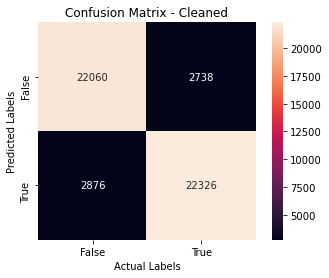

In [41]:
sns.heatmap(conf_mat_clean.T, square = True, annot = True, fmt = 'd', 
            xticklabels = y.unique(), yticklabels = y.unique())
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix - Cleaned');

In [42]:
print("\nThe accuracy on the cleaned test set is {0:0.3f}.".format(accuracy_score(y_test, predicted_clean)))
print("\nThe precision on the cleaned test set is {0:0.3f}.".format(precision_score(y_test, predicted_clean)))
print("\nThe recall on the cleaned test set is {0:0.3f}.".format(recall_score(y_test, predicted_clean)))


The accuracy on the cleaned test set is 0.888.

The precision on the cleaned test set is 0.886.

The recall on the cleaned test set is 0.891.


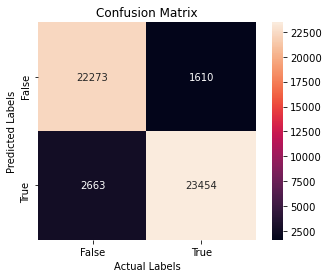

In [43]:
conf_mat = confusion_matrix(y_test, predicted)
sns.heatmap(conf_mat.T, square = True, annot = True, fmt = 'd', 
            xticklabels = y.unique(), yticklabels = y.unique())
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix');

In [44]:
print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, predicted)))
print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, predicted)))
print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, predicted)))


The accuracy on the test set is 0.915.

The precision on the test set is 0.898.

The recall on the test set is 0.936.


## ROC Curve

In [45]:
y_test_values = y_test.values
y_test_values = np.where(y_test_values, 1, 0)
y_test_values

array([1, 0, 0, ..., 1, 1, 0])

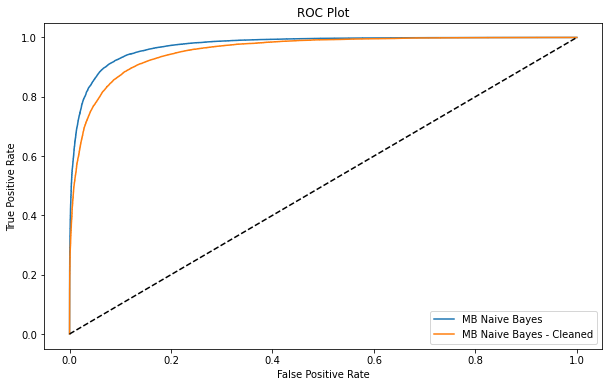

In [46]:
probs = nb_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_values, probs)

probs_clean = nb_pipeline_clean.predict_proba(X_test_clean)[:, 1]
fpr_clean, tpr_clean, thresholds_clean = roc_curve(y_test_values, probs_clean)

x = np.linspace(0, 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fpr, tpr, label='MB Naive Bayes')
ax.plot(fpr_clean, tpr_clean, label='MB Naive Bayes - Cleaned')
ax.plot(x, x, color='black', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot')
ax.legend();

## Word Cloud

In [47]:
text_humor = ' '.join(clean_corpus(texts_humor.text))

In [48]:
text_serious = ' '.join(clean_corpus(texts_serious.text))

In [49]:
#https://amueller.github.io/word_cloud/auto_examples/masked.html#sphx-glr-auto-examples-masked-py
from os import path
from PIL import Image
import os

# Define path
path_ = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask / color image taken from
laugh_emoji = np.array(Image.open(path.join(path_, "images/rolling-on-the-floor-laughing.png")))
straight_face_emoji = np.array(Image.open(path.join(path_, "images/expressionless-face.png")))

#stop_words = set(STOPWORDS)
#s_words.add("said")

wc_humor = WordCloud(background_color="black", max_words=None, mask=laugh_emoji, max_font_size=40)

wc_serious = WordCloud(background_color="black", max_words=None, mask=straight_face_emoji, max_font_size=40)

# generate word cloud
wc_humor.generate(text_humor)
wc_serious.generate(text_serious)

# create coloring from image
humor_image_colors = ImageColorGenerator(laugh_emoji)
serious_image_colors = ImageColorGenerator(straight_face_emoji)

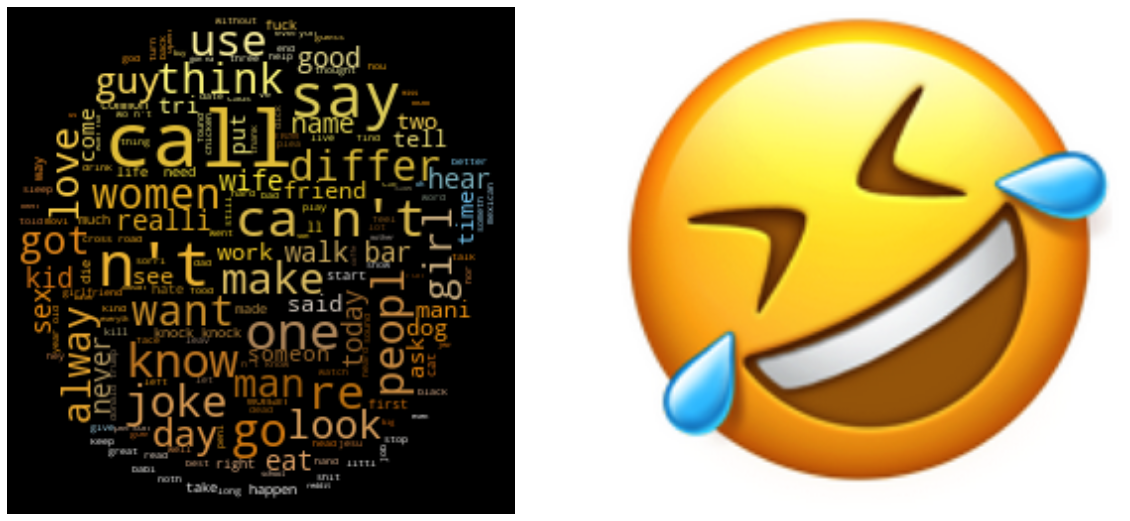

In [50]:
# showa
fig, axes = plt.subplots(1, 2, figsize=(20,20))
#axes[0].imshow(wc, interpolation="bilinear")
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
axes[0].imshow(wc_humor.recolor(color_func=humor_image_colors), interpolation="bilinear")
axes[1].imshow(laugh_emoji, cmap=plt.cm.gray, interpolation="bilinear")

for ax in axes:
    ax.set_axis_off()
plt.show()

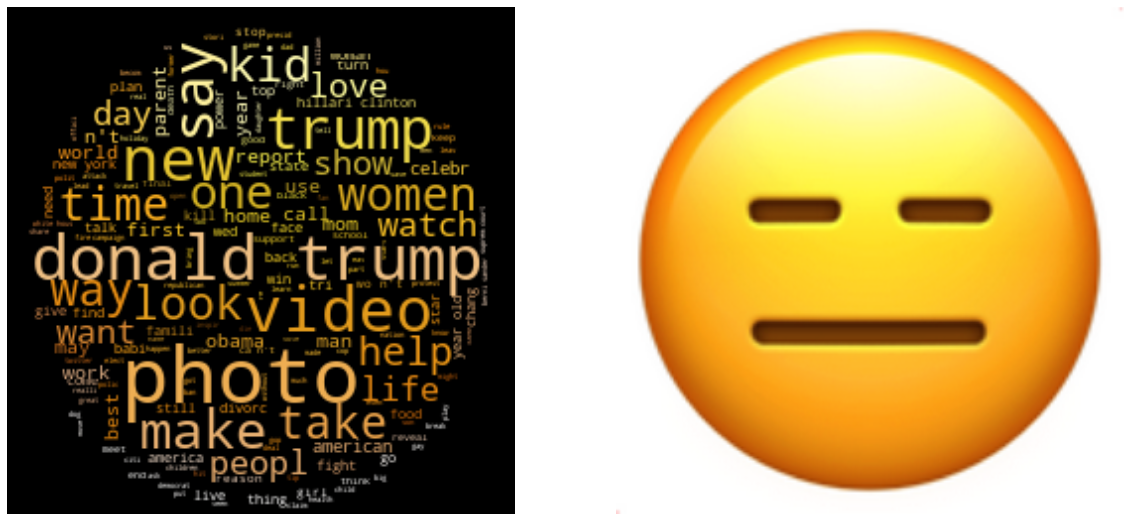

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20,20))
axes[0].imshow(wc_serious.recolor(color_func=serious_image_colors), interpolation="bilinear")
axes[1].imshow(straight_face_emoji, cmap=plt.cm.gray, interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()
plt.show()

> If time, want to see how to get rid of apostrophies. Also, might want to use normal wordcloud and not map to colors, since these are so similar.

In [52]:
str(text_humor).lower().count('call')

9926

In [53]:
str(text_serious).lower().count('photo')

6701

## Other Models

Build model(s) to classify text as humorous or serious
* Identify different clusters/topics within humorous text
* Identify different clusters/topics of serious text
* Create a program to generate jokes

* NLP - TFIDF gives tokens but not order, etc
* Naive Bayes Text Classification - supervised
* Basic NN, MLP - supervised
* K-means topic clustering - unsupervised
* PCA - from Chelsea: remember!! PCA components point in the direction of variance, and are sorted in descending order where the first component describes most variance. Don't forget that pca.variance_ (or explained_variance_? idk) tells you how much that component is describing and we can plot the "scree" to find how many components are worth keeping! so keeping all 10 components in your word cloud kept a lot of unsignificant words!
* Topic Modeling with NMF? - Unsupervised
* XGBoost?
* CNN? - sequence of tokens (RNN? classifier)